In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score

### Carregando Dataset do professor

In [2]:
# testando amostras do professor
df_train = pd.read_csv('dataset/har-example-mo436/train.csv')
df_test = pd.read_csv('dataset/har-example-mo436/test.csv')
df_val = pd.read_csv('dataset/har-example-mo436/validation.csv')

# pegando só porcentagens das amostras
percent = 100
porcentagem = f"predictions_{percent}_m2"
# df_90, df_10 = train_test_split(df_train, test_size=percent/100, random_state=42) # dataframes de treino e validacao
# df_train = df_10

X_train = df_train.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window', 'standard activity code'])
X_test = df_test.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window', 'standard activity code'])
X_val = df_val.drop(columns=[df_train.columns[0], 'gyro-end-time', 'level_0', 'accel-end-time', 'gyro-start-time', 'index', 'user', 'serial', 'accel-start-time', 'csv', 'timestamp diff', 'activity code', 'window', 'standard activity code'])

y_train = df_train.pop('standard activity code')
y_test = df_test.pop('standard activity code')
y_val = df_val.pop('standard activity code')

print("shape train: ", X_train.shape)
print("shape test: ", X_test.shape)
print("shape valid: ", X_val.shape)

shape train:  (60, 360)
shape test:  (24, 360)
shape valid:  (24, 360)


### Dataset

In [3]:
class CSVLabeledDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.transform = transform

        self.features = X
        self.labels = y

        if self.transform:
            self.features = self.transform(self.features)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sample, label

### Transforms

In [4]:
class Jitter:
    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def __call__(self, x):
        noise = np.random.normal(loc=0, scale=self.sigma, size=x.shape)
        return x + noise

class Scaling:
    def __init__(self, sigma=0.1):
        self.sigma = sigma

    def __call__(self, x):
        factor = np.random.normal(loc=1.0, scale=self.sigma)
        return x * factor

class TimeShift:
    def __init__(self, max_shift=50):
        self.max_shift = max_shift

    def __call__(self, x):
        shift = np.random.randint(-self.max_shift, self.max_shift)
        return np.roll(x, shift)

# classe de transformacoes nos dados
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for t in self.transforms:
            if callable(t):
                x = t(x)
            else:
                x = t.fit_transform(x)
        return x

### Carregando Dataset

In [5]:
def createDataLoader(X_train, X_test, X_val, y_train, y_test, y_val, batch_size=32):
    # scaler = StandardScaler()
    train_transform = Compose([
        StandardScaler(),
        # Jitter(),
        # Scaling(),
        # TimeShift()
    ])
    valid_test_transform = Compose([
        StandardScaler()
    ])

    train_dataset = CSVLabeledDataset(X_train, y_train, transform=train_transform)
    test_dataset = CSVLabeledDataset(X_test, y_test, transform=valid_test_transform)
    val_dataset = CSVLabeledDataset(X_val, y_val, transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader

In [6]:
train_dataset, test_dataset, val_dataset, train_loader, test_loader, val_loader = createDataLoader(X_train.values, X_test.values, X_val.values, y_train.values, y_test.values, y_val.values)

In [7]:
print(len(train_dataset), len(train_loader), len(test_loader))

60 2 1


In [8]:
for batch_idx, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 1, 360])
torch.Size([32])


In [9]:
for batch_idx, (x, y) in enumerate(val_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([24, 1, 360])
torch.Size([24])


In [10]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()
        self.device = device

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = F.leaky_relu(self.hidden2mean(h_n), negative_slope=0.01)
        logvar = F.leaky_relu(self.hidden2logvar(h_n), negative_slope=0.01)
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
print(device)

input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
epochs = 350

print(input_dim)

mps
360


In [12]:
# carregando modelo
model_path = "model/vae.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

print(model)

TemporalVAE(
  (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=360, out_features=360, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [13]:
class Net(nn.Module):
    def __init__(self, model, input_dim):
        super(Net, self).__init__()
        self.encode = model

        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        self.fc1 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o encoder do VAE com residuo (acc ~ 90%)
        # self.latent2hidden = nn.Linear(64, 128)
        # self.decoder_lstm = nn.LSTM(128, input_dim, 6, batch_first=True, bidirectional=False, dropout=0.2)
        # self.output_layer = nn.Linear(input_dim, input_dim)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # self.fc1 = nn.Linear(input_dim, 64)
        # self.dropout = nn.Dropout(0.2)
        # self.fc2 = nn.Linear(64, 6)

        # Freeze encoder parameters
        for param in model.parameters():
            param.requires_grad = False
        
    def forward(self, x):
        # usando o encoder do VAE com espaco latente (acc ~ 78%)
        mean, logvar, residual = self.encode.encode(x)
        # print(mean)
        # z = self.encode.reparameterize(mean, logvar)
        # print(z.shape)
        x = torch.sigmoid(self.fc1(mean)) #  self.fc1(mean)
        x = self.dropout(x)
        x = self.fc2(x)

        # (ERRADO) usando encoder do VAE, somando o residuo e expandindo para o shape original (acc ~ 90%)
        # mean, logvar, residual = self.encode.encode(x)
        # z = self.encode.reparameterize(mean, logvar)
        # # print(z)
        # seq_len = x.size(1)
        # x = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1).view(z.size(0), -1)
        # x, _ = self.decoder_lstm(x)
        # x = self.dropout(x)
        # residual = residual.squeeze(1)
        # x += residual
        # x = self.output_layer(x)
        # x = torch.sigmoid(self.fc1(x)) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)

        # print("mean output shape:", mean.shape)
        # print("logvar output shape:", logvar.shape)
        # print("residual output shape:", residual.shape)
        # print("z output shape:", z.shape)
        # print("seq_len output shape:", seq_len)
        # print("x output shape:", x.shape)
        # return

        # (ERRADO) usando o VAE completo (acc ~ 95%)
        # recon_x, mean, logvar = self.encode.forward(x)
        # # print(recon_x)
        # x = torch.sigmoid(self.fc1(recon_x.view(recon_x.size(0), -1))) #  self.fc1(mean)
        # x = self.dropout(x)
        # x = self.fc2(x)
        return x

In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)

In [15]:
net = Net(model, input_dim=input_dim).to(device)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=0.001) # fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001) # freeze

print(net)

Net(
  (encode): TemporalVAE(
    (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
    (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
    (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
    (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
    (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
    (output_layer): Linear(in_features=360, out_features=360, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=64, out_features=6, bias=True)
)


In [16]:
def trainModel(model, train_loader, criterion, optimizer, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for x, y in train_loader:
    data = x.to(device)
    label = y.to(device)
    
    optimizer.zero_grad()
    logits = model(data)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = logits.max(1)
    total += label.size(0)
    correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

def evalModel(model, val_loader, criterion, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():
    for x, y in val_loader:
      data = x.to(device)
      label = y.to(device)
      logits = model(data)
      loss = criterion(logits, label)

      running_loss += loss.item()
      _, predicted = logits.max(1)
      total += label.size(0)
      correct += predicted.eq(label).sum().item()

  epoch_loss = running_loss / len(val_loader)
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

In [17]:
# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# best_val_acc = 0.0

# for epoch in range(epochs):
#   train_loss, train_acc = trainModel(net, train_loader, criterion, optimizer, device)
#   val_loss, val_acc = evalModel(net, val_loader, criterion, device)

#   train_losses.append(train_loss)
#   train_accuracies.append(train_acc)

#   val_losses.append(val_loss)
#   val_accuracies.append(val_acc)

#   print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

Epoch 1/350, Train Loss: 1.9915, Train Acc: 16.67, Val Loss: 1.9224, Val Acc: 16.67
Epoch 2/350, Train Loss: 1.8859, Train Acc: 18.33, Val Loss: 1.9015, Val Acc: 16.67
Epoch 3/350, Train Loss: 1.9378, Train Acc: 15.00, Val Loss: 1.8836, Val Acc: 16.67
Epoch 4/350, Train Loss: 1.9527, Train Acc: 16.67, Val Loss: 1.8689, Val Acc: 16.67
Epoch 5/350, Train Loss: 1.8711, Train Acc: 26.67, Val Loss: 1.8562, Val Acc: 16.67
Epoch 6/350, Train Loss: 1.8581, Train Acc: 21.67, Val Loss: 1.8453, Val Acc: 16.67
Epoch 7/350, Train Loss: 1.8579, Train Acc: 20.00, Val Loss: 1.8361, Val Acc: 16.67
Epoch 8/350, Train Loss: 1.7939, Train Acc: 23.33, Val Loss: 1.8282, Val Acc: 16.67
Epoch 9/350, Train Loss: 1.8207, Train Acc: 13.33, Val Loss: 1.8218, Val Acc: 16.67
Epoch 10/350, Train Loss: 1.8031, Train Acc: 20.00, Val Loss: 1.8162, Val Acc: 16.67
Epoch 11/350, Train Loss: 1.8041, Train Acc: 21.67, Val Loss: 1.8112, Val Acc: 16.67
Epoch 12/350, Train Loss: 1.7673, Train Acc: 30.00, Val Loss: 1.8071, Val 

In [ ]:
def cross_validate(model_class, dataset, k_folds=5, num_epochs=100, batch_size=32, learning_rate=0.001):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    results = {}

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold+1}/{k_folds}')

        # Criando os conjuntos de treino e validação para este fold
        train_subsampler = Subset(dataset, train_ids)
        val_subsampler = Subset(dataset, val_ids)

        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

        # Inicializando o modelo, otimizador e definindo a função de perda
        model = model_class.to(device)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            train_loss, train_acc = trainModel(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc = evalModel(model, val_loader, criterion, device)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f'Fold {fold+1}, Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

        results[fold] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        }

    avg_val_acc = np.mean([results[fold]['val_accuracies'][-1] for fold in range(k_folds)])
    print(f'Average Validation Accuracy: {avg_val_acc:.2f}')

    return results

# Aplicando o K-Fold Cross-Validation
results_train = cross_validate(net, train_dataset, k_folds=5, num_epochs=350)
results_test = cross_validate(net, train_dataset, k_folds=5, num_epochs=350)
results_val = cross_validate(net, train_dataset, k_folds=5, num_epochs=350)

In [18]:
# avaliando modelo sem augmentation
test_loss, test_acc = evalModel(net, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}') # Test Loss: 1.6467, Test Acc: 35.87

Test Loss: 1.8108, Test Acc: 20.83


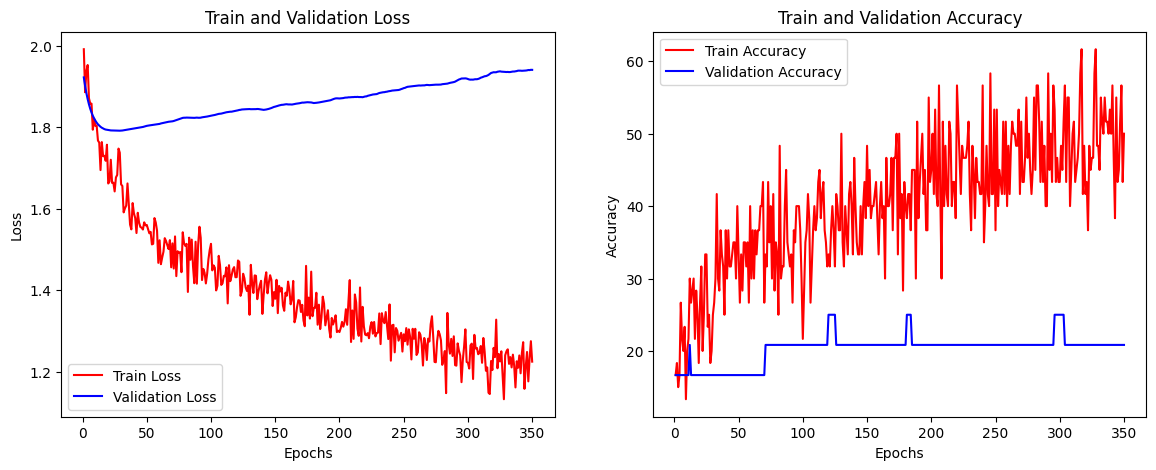

In [19]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 36 epocas porque com early stopping so rodou 36 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_accuracies, 'r', label='Train Accuracy')
plt.plot(epocas, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
# # salvando modelo
# torch.save(net.state_dict(), "model/downstream.pth")

In [21]:
# # carregando modelo
# model_path = "model/downstream.pth"

# # Criar uma instância do modelo
# model_backbone = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
# net = Net(model_backbone, input_dim=input_dim).to(device)
# # Carregar o estado salvo
# state_dict = torch.load(model_path)

# # Carregar o estado no modelo
# net.load_state_dict(state_dict)

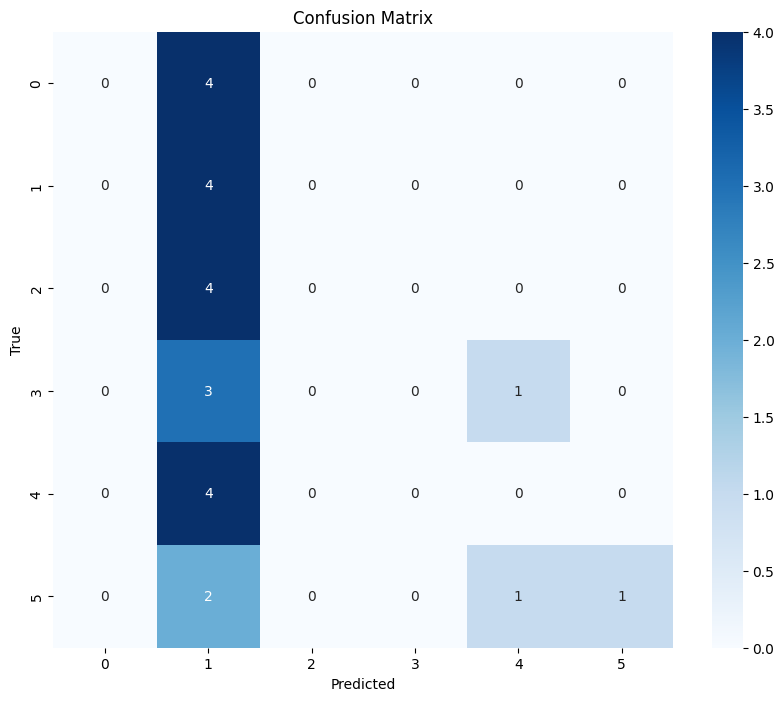

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.19      1.00      0.32         4
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         4
           5       1.00      0.25      0.40         4

    accuracy                           0.21        24
   macro avg       0.20      0.21      0.12        24
weighted avg       0.20      0.21      0.12        24



/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/filipealvessampaio/miniconda3/envs/vae/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [22]:
# Obter previsões do conjunto de teste
net.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_idx, (x, y) in enumerate(test_loader):
        data = x.to(device)
        label = y.to(device)
        outputs = net(data)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Calcular a matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

# Visualizar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Relatório de classificação
print(classification_report(all_labels, all_preds))

In [23]:
# Calculando o F1-score para cada classe
f1_scores = f1_score(all_labels, all_preds, average=None)
for i, f1 in enumerate(f1_scores):
    print(f'F1-Score for class {i}: {f1:.2f}')

# Calculando a média macro do F1-score
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Macro F1-Score: {macro_f1:.2f}')

# Calculando a média ponderada do F1-score
weighted_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'Weighted F1-Score: {weighted_f1:.2f}')

F1-Score for class 0: 0.00
F1-Score for class 1: 0.32
F1-Score for class 2: 0.00
F1-Score for class 3: 0.00
F1-Score for class 4: 0.00
F1-Score for class 5: 0.40
Macro F1-Score: 0.12
Weighted F1-Score: 0.12


In [24]:
pred_labels = np.array(all_preds)
true_labels = np.array(all_labels)

csv = pd.DataFrame({
    'real': true_labels,
    'prediction': pred_labels,
})

csv.to_csv(f'{porcentagem}.dat', sep=" ", index=False)

In [25]:
true_labels

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5])